This is a demonstration of how one defines a Nerual Network using torch's Modules. This notebook defines the simplest neural network with only Input layers, Fully Connected Layers and Output Layers.\
For ease of reference, this architecture of the neural network is referred to as a 'Fully Connected Network' throughout the whole topic.

In [1]:
import torch

from torch import nn
from torch.utils.data import random_split, DataLoader, Dataset

import matplotlib.pyplot as plt

import math

# Sample Data

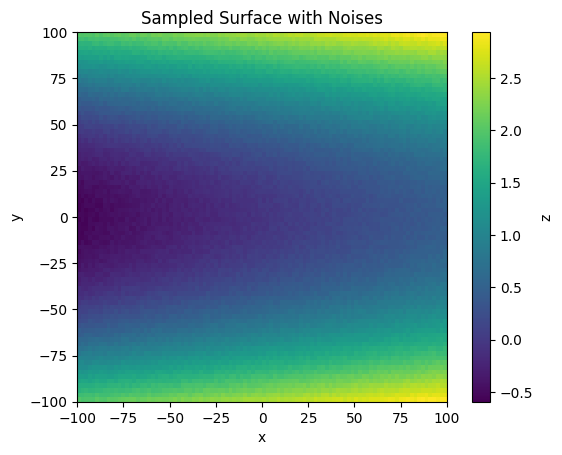

In [2]:
x = torch.linspace(-100, 100, 100)
y = torch.linspace(-100, 100, 80)

xx, yy = torch.meshgrid(x, y, indexing='xy')

z = (5 * xx + (0.5 * yy) ** 2 - 100) / 1000 + torch.rand(xx.shape) * .1


plt.imshow(z, extent=[x[0], x[-1], y[0], y[-1]])
plt.title('Sampled Surface with Noises')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('z');

In [3]:
features = torch.cat([xx.reshape((-1,1)), yy.reshape((-1,1))], 1)
labels = z.reshape((-1, 1))

# First Model Definition

In [12]:
class ParabolaDataset(Dataset):
    def __init__(self, features, targets):
        if features.shape[0] != targets.shape[0]:
            raise ValueError('Features and Labels have different lengths!')
        super().__init__()
        self.features = features
        self.targets = targets
    
    def __len__(self) -> int:
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]

In [13]:
class SimpleNetwork(nn.Module):
    """
    A simple Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, values):
        return self.layers(values)

In [27]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: nn.Module,
    track_loss: bool = False
):
    """
    Performs backpropogation on `model` using `optimizer`.

    :param nn.Module model: The model on which to perform backpropogation.
    :param nn.utils.data.DataLoader train_loader: A DataLoader dispatching batches
        for each backpropogations.
    :param nn.Module loss_fn: The loss function to based on which to compute gradients.
    :param nn.Module optimizer: The optimization algorithm for gradient descent.
    :param bool track_loss: Whether or not to print out statistics on each backpropogation.
        This is `False` by default.
    """
    model.train()
    if track_loss:
        num_digits = int(math.log10(len(train_loader))) + 1
    losses = []
    for batch, (X, y) in enumerate(train_loader, start=1):
        pred_value = model(X)
        loss = loss_fn(pred_value, y)

        # Compute the gradient with loss.backward()
        # Then backpropogate with optimizer.step()
        # However, to avoid accumulation of previous backward passes
        # we need to call optimizer.zero_grad() to zero out the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if track_loss:
            print(f"Batch {batch:>{num_digits}}/{len(train_loader)} || Loss: {loss}")
        losses.append(loss.detach().item())
    return losses
@torch.no_grad()
def test_model(
    model: nn.Module,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    compute_accuracy: bool
) -> tuple[float, float]:
    """
    Evaluate `model` based on `loss_fn` and return the average score(s).

    :param nn.Module model: The model on which to perform evaluation.
    :param nn.utils.data.DataLoader test_loader: A DataLoader containing test data.
    :param nn.Module loss_fn: The loss function to based on which to compute metrics.
    :param bool compute_accuracy: Whether or not to compute accuracy. This is only
        meaningful in the case the `model` is a classifier.
    :return: The average loss (per batch) and average accuracy (per sample). If
        `compute_accuracy=False` then average accuracy returned is 0.
    :rtype: tuple[float, float]
    """
    model.eval()
    total_loss, total_accuracy = 0, 0
    for X, y in test_loader:
        pred = model(X)
        total_loss += loss_fn(pred, y)
        if compute_accuracy:
            labels = (pred.argmax(dim=1) == y)
            total_accuracy += labels.type(torch.int).sum().item()
    return total_loss / len(test_loader), total_accuracy / len(test_loader.dataset)

# Training and Evaluation

In [28]:
def train_epochs(
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module,
    epochs: int
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10
    loss = {
        'train': [],
        'eval': []
    }

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ', flush=True)
        train_loss = train_model(
            model, train_loader, loss_fn,
            optimizer
        )
        loss['train'].append(sum(train_loss) / len(train_loss))
        
        test_loss, acc = test_model(model, test_loader, loss_fn, False)
        if not epoch % update_rate:
            print(f"Average Loss: {test_loss:.6f}", flush=True)
        loss['eval'].append(test_loss)
    return loss

In [46]:
batch_size = 64
learning_rate = 5e-5

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

model = SimpleNetwork(2, 1, 10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

global_loss = {
    'train': [],
    'eval': []
}

In [63]:
loss = train_epochs(
    model, train_loader, test_loader, loss_fn, optimizer, 100
)
global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

Epoch   1/100 || Average Loss: 0.586488
Epoch  11/100 || Average Loss: 0.586254
Epoch  21/100 || Average Loss: 0.586031
Epoch  31/100 || Average Loss: 0.585822
Epoch  41/100 || Average Loss: 0.585623
Epoch  51/100 || Average Loss: 0.585437
Epoch  61/100 || Average Loss: 0.585261
Epoch  71/100 || Average Loss: 0.585095
Epoch  81/100 || Average Loss: 0.584938
Epoch  91/100 || Average Loss: 0.584790


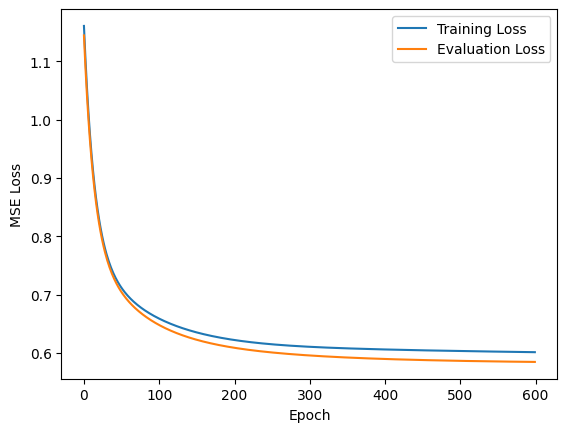

In [64]:
plt.plot(global_loss['train'], label='Training Loss')
plt.plot(global_loss['eval'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

# Weights Interpretation
The purpose of this section is to demonstrate how the activation function introduce non-linearity into the model.
This also show how good the model can fit into seen data.\
However, this ONLY shows a part of the model's performance. One must also judge how good the model fits into unseen
data in order to accurately determine the model's performance.

In [65]:
state_dict = model.state_dict()
state_dict

OrderedDict([('layers.1.weight',
              tensor([[-0.6071, -0.7589],
                      [ 0.3275,  0.2472],
                      [ 0.1389,  0.2594],
                      [-0.6647,  0.2040],
                      [-0.4379, -0.0351],
                      [-0.0853,  0.3802],
                      [ 0.0713,  0.2556],
                      [-0.4541,  0.1896],
                      [ 0.5270,  0.2594],
                      [-0.6519, -0.4241]])),
             ('layers.1.bias',
              tensor([ 0.5477,  0.2167, -0.6543,  0.2470, -0.3716, -0.5316, -0.3789, -0.0764,
                      -0.6734,  0.4429])),
             ('layers.3.weight',
              tensor([[ 0.2720,  0.1683,  0.2777,  0.0119, -0.1885, -0.1347,  0.0339, -0.1345,
                        0.2843,  0.1251]])),
             ('layers.3.bias', tensor([0.4424]))])

In [67]:
linear_comb = features @ state_dict['layers.1.weight'].T
first_layer_res = torch.sigmoid(linear_comb + state_dict['layers.1.bias'])
linear_comb_2 = first_layer_res @ state_dict['layers.3.weight'].T
output_layer = linear_comb_2 + state_dict['layers.3.bias']
output_layer

# or easily call model(features)
# remember to set model to eval before interference

tensor([[0.5284],
        [0.5284],
        [0.5284],
        ...,
        [1.0719],
        [1.0719],
        [1.0719]])

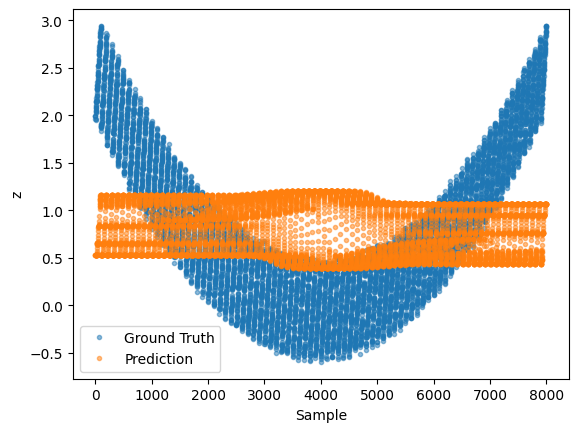

In [68]:
plt.plot(labels, '.', label='Ground Truth', alpha=.5)
plt.plot(output_layer, '.', label='Prediction', alpha=.5)
plt.xlabel('Sample')
plt.ylabel('z')
plt.legend();

In [69]:
def draw_predicted_surface(
    heights, ax,
    title='',
    extent=None
):
    img = ax.imshow(heights, extent=extent)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = ax.get_figure().colorbar(img)
    cbar.set_label('z')
    return ax, img

(<Axes: title={'center': 'Predicted Surface from Model'}, xlabel='x', ylabel='y'>,
 <matplotlib.image.AxesImage at 0x1f3be3e65d0>)

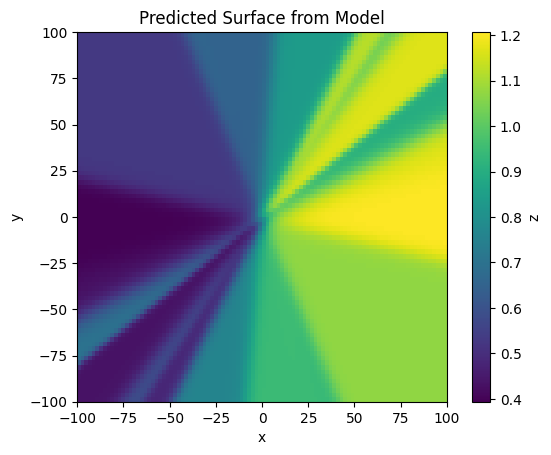

In [70]:
draw_predicted_surface(
    output_layer.reshape(xx.shape), plt.gca(),
    'Predicted Surface from Model',
    [x[0], x[-1], y[0], y[-1]]
)

# Second Model Definition

In [71]:
class MultiLayerPerceptron(nn.Module):
    """
    A Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self,
        input_output_dim: tuple[int, int],
        hidden_dim: tuple[int]
    ):
        super().__init__()
        self.layers = nn.Sequential(nn.Flatten())

        relu = nn.ReLU()
        hidden_dim = input_output_dim[0:1] + hidden_dim
        for i in range(1, len(hidden_dim)):
            self.layers.add_module(f'{2 * i - 1}', nn.Linear(hidden_dim[i-1], hidden_dim[i]))
            self.layers.add_module(f'{2 * i}', relu)
        self.layers.add_module(f'out', nn.Linear(hidden_dim[-1], input_output_dim[1]))
        
    def forward(self, values):
        return self.layers(values)

## Training

Here, we used the ReLU function which has much better convergence for values further away from 0 compared to Sigmoid. Furthermore, we switched to a different optimization algorithm where the learning rate will be adaptively changed based on the model's convergence.

In [86]:
learning_rate = 5e-5

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

mlp_model_1 = MultiLayerPerceptron((2, 1), (10, 10))
mlp_model_2 = MultiLayerPerceptron((2, 1), (50, 50))
mlp_model_3 = MultiLayerPerceptron((2, 1), (50, 50, 50, 50))

loss_fns = [nn.MSELoss(), nn.MSELoss(), nn.MSELoss()]
optimizers = [
    torch.optim.Adam(mlp_model_1.parameters(), lr=learning_rate),
    torch.optim.Adam(mlp_model_2.parameters(), lr=learning_rate),
    torch.optim.Adam(mlp_model_3.parameters(), lr=learning_rate),
]
gloabl_losses = [
    {'train': [], 'eval': []} for _ in range(3)
]

In [92]:
epochs = 50

print('Training First Model:')
loss = train_epochs(mlp_model_1, train_loader, test_loader, loss_fns[0], optimizers[0],
             epochs)
gloabl_losses[0]['train'].extend(loss['train'])
gloabl_losses[0]['eval'].extend(loss['eval'])

print('\nTraining Second Model:')
loss = train_epochs(mlp_model_2, train_loader, test_loader, loss_fns[1], optimizers[1],
             epochs)
gloabl_losses[1]['train'].extend(loss['train'])
gloabl_losses[1]['eval'].extend(loss['eval'])

print('\nTraining Third Model:')
loss = train_epochs(mlp_model_3, train_loader, test_loader, loss_fns[2], optimizers[2],
             epochs)
gloabl_losses[2]['train'].extend(loss['train'])
gloabl_losses[2]['eval'].extend(loss['eval'])

Training First Model:
Epoch  1/50 || Average Loss: 0.032874
Epoch 11/50 || Average Loss: 0.030732
Epoch 21/50 || Average Loss: 0.028964
Epoch 31/50 || Average Loss: 0.028531
Epoch 41/50 || Average Loss: 0.027769

Training Second Model:
Epoch  1/50 || Average Loss: 0.022246
Epoch 11/50 || Average Loss: 0.021486
Epoch 21/50 || Average Loss: 0.021190
Epoch 31/50 || Average Loss: 0.021223
Epoch 41/50 || Average Loss: 0.020729

Training Third Model:
Epoch  1/50 || Average Loss: 0.002421
Epoch 11/50 || Average Loss: 0.002202
Epoch 21/50 || Average Loss: 0.001627
Epoch 31/50 || Average Loss: 0.001555
Epoch 41/50 || Average Loss: 0.001470


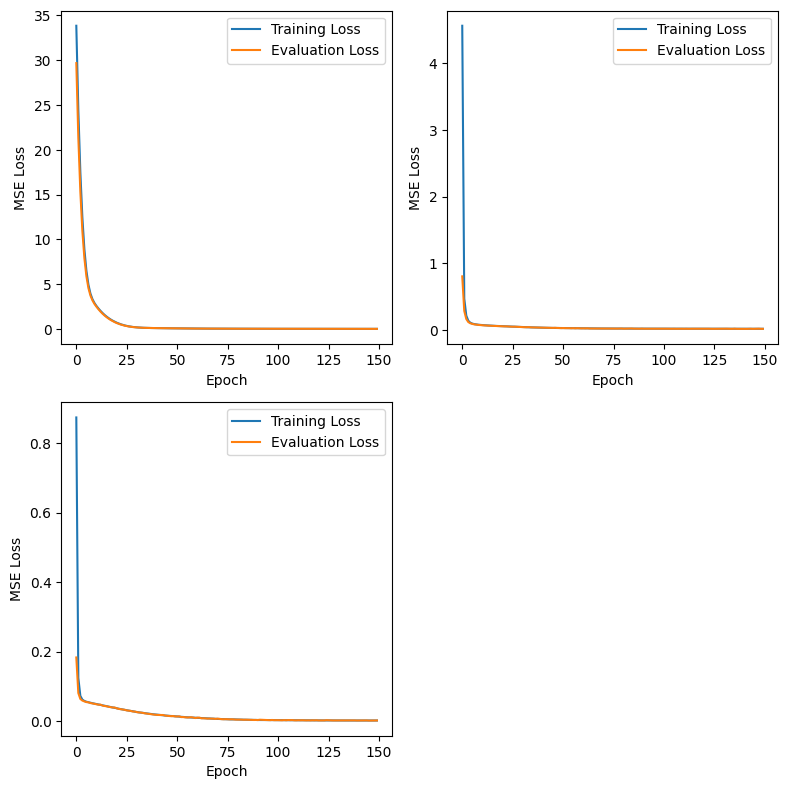

In [96]:
fig = plt.figure(figsize=(8, 8))
axes = fig.subplot_mosaic([[0, 1], [2, '.']])

for i, loss in enumerate(gloabl_losses):
    axes[i].plot(loss['train'], label='Training Loss')
    axes[i].plot(loss['eval'], label='Evaluation Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()
fig.tight_layout();

## Inference

We can see that these models can converge very well. This is shown by the deep hidden layers being able to capture the non-linearities in the data. For the third model with four hidden layers, the model can almost perfectly replicate the surface.

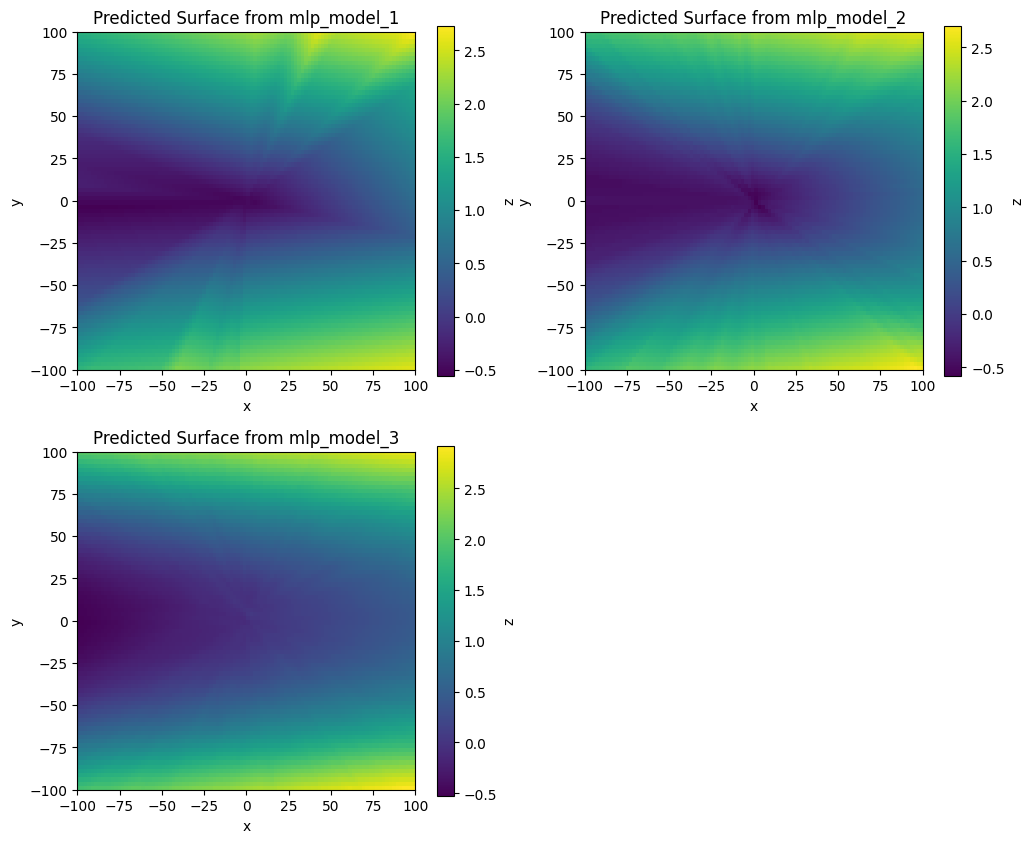

In [94]:
mlp_model_1.eval()
mlp_model_2.eval()
mlp_model_3.eval()
predictions = [
    mlp_model_1(features).detach(),
    mlp_model_2(features).detach(),
    mlp_model_3(features).detach(),
]


fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
axes = fig.subplot_mosaic(
    [[0, 1], [2, '.']]
)

extent = [x[0], x[-1], y[0], y[-1]]
temp_title_fn = lambda num: f'Predicted Surface from mlp_model_{num}'
draw_predicted_surface(
    predictions[0].reshape(xx.shape), axes[0],
    temp_title_fn(1),
    extent=extent
)
draw_predicted_surface(
    predictions[1].reshape(xx.shape), axes[1],
    temp_title_fn(2),
    extent=extent
)
draw_predicted_surface(
    predictions[2].reshape(xx.shape), axes[2],
    temp_title_fn(3),
    extent=extent
);